---
toc: false
page-layout: full
execute: 
  enabled: false
---

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)

## Week 12A: Predictive modeling with scikit-learn

- Nov 19, 2023
- Section 401


## Last week

- A crash course on clustering 
    - non-spatial: k-means
    - spatial: DBSCAN
- An introduction to scikit-learn

## Reminder: clustering is an example of *unsupervised learning*

- Clustering tries to detect previously unknown structure in your input dataset
- Only requires the data set as input, no associated labels or prediction targets

## Today: an example of *supervised learning*


- **Key distinction**: requires a training data set as well as the desired solutions (called *labels*) as inputs to the algorithm
- Two main types:
    - **Classification**: samples belong to two or more classes and we want to learn from already labeled data how to predict the class of unlabeled data. 
    - **Regression**: predicting a continuous variable from a training dataset


<img src="imgs/classification-vs-regression.png" width=800></img>

## Examples:

- **Classification**: a spam filter to classify new emails as spam / not spam based on past examples
- **Regression**: predicting housing prices based on property characteristics

**Today, we'll walk through an end-to-end regression example to predict Philadelphia's housing prices** 

## Model-based learning

- Select a model that can represent the data 
- Use the training data to identify the best model parameters (by minimizing a *cost function*)
- Make predictions on new data — and hope that your model *generalizes* well to new data!


## Machine learning is really just an **optimization problem**

Given your training set of data, which model parameters best represent the observed data?

### 1. Choose a model

<img src="imgs/model-1.png" width=400></img>

### 2. The model has an associated cost function

The *cost function* measures the difference between the model's predictions and the observed data

<img src="imgs/model-2.png" width=450></img>

### 3. "Learn" the best model parameters

In scikit-learn, you will call the `fit()` method on your algorithm.

<img src="imgs/model-3.png" width=600></img>


## Recap: the steps involved

1. Wrangle and understand data. 
1. Select a model that would be best for your dataset.
1. Train the model on the training data — the learning algorithm searches for the best model parameters
1. Apply the model to new data to make predictions.

**Key goal: how we can do this in a way to ensure the model is as generalizable as possible?**

## What could go wrong?


<img src=https://media.giphy.com/media/nDxjSaLT9gFig/giphy.gif width=600></img>

### Mistake #1: "bad data"

Or: "garbage in, garbage out" 

**Common issues:**

- Not enough training data
- Training data isn't representative of the unseen data that you want to make predictions for
- Poor quality data — errors, missing data, outliers
- Poor features in the training set
    - You'll often hear the phrase *feature engineering* to describe the process of improving your input dataset: 
    - Involves: feature selection, feature extraction, creating new features

### Mistake #2: "bad algorithm"

- Overfitting the training data (more on this shortly)
    - model performs well, too well in fact, on the training set, and does not generalize well
    - model is **too complex** for your training set
- Underfitting the training data
    - model is **not complex enough**
    - predictions will be inacurrate, but adding more model parameters (making it more complex) will help improve the accuracy

## Regularization: keeping it simple

- We can *regularize* our model to prevent the model from getting too complex and avoid overfitting
- Adds a penalty to the cost function that prevents parameters from getting too large
- Can effectively think of regularization as forcing some model parameters to be close, not quite, zero

<img src="imgs/regularization.png" width=600></img>

##  Key question: How do we know if a model will perform well on new data?

<img src="https://media.giphy.com/media/3ohhwjIjLLWBh4EQRW/giphy.gif" width=600></img>

**Note:** Crossing your fingers and hoping for the best is not the recommended strategy

## Option #1: a train/test split

- Split your data into two sets: the *training set* and the *test set*
- Train on the training set and test on the test set!
- The accuracy on the test set provides a measure of how well your model generalizes

Common to use 80% of data for your training set and 20% for your test set

- Still run the risk that you've selected the best model parameters for this **specific** training/test combination
- For example: 
    - Does the model work best on a 80/20 split, a 60/40 split, 70/30? How to decide the test/train split?
    - If you are using regularization, did your regularization strength parameter work only on this specific training set?

## Option #2: *k*-fold cross-validation

1. Break the data into a training set and test set
1. Split the training set into *k* subsets (or folds), holding out one subset as the test set
1. Run the learning algorithm on each combination of subsets, using the average of all of the runs to find the best fitting model parameters

::: {.callout-tip}
For more information, see the [scikit-learn docs](https://scikit-learn.org/stable/modules/cross_validation.html).
:::

<img src="imgs/crossval.png" width=600></img>

## Let's try out a simple example: does money make people happier?

We'll load data compiled from two data sources:
- The *Better Life Index* from the [OECD's website](https://stats.oecd.org/index.aspx?DataSetCode=BLI)
- GDP per capita from the [IMF's website](https://www.imf.org/external/pubs/ft/weo/2016/01/weodata/weorept.aspx?pr.x=32&pr.y=8&sy=2015&ey=2015&scsm=1&ssd=1&sort=country&ds=.&br=1&c=512,668,914,672,612,946,614,137,311,962,213,674,911,676,193,548,122,556,912,678,313,181,419,867,513,682,316,684,913,273,124,868,339,921,638,948,514,943,218,686,963,688,616,518,223,728,516,558,918,138,748,196,618,278,624,692,522,694,622,142,156,449,626,564,628,565,228,283,924,853,233,288,632,293,636,566,634,964,238,182,662,453,960,968,423,922,935,714,128,862,611,135,321,716,243,456,248,722,469,942,253,718,642,724,643,576,939,936,644,961,819,813,172,199,132,733,646,184,648,524,915,361,134,362,652,364,174,732,328,366,258,734,656,144,654,146,336,463,263,528,268,923,532,738,944,578,176,537,534,742,536,866,429,369,433,744,178,186,436,925,136,869,343,746,158,926,439,466,916,112,664,111,826,298,542,927,967,846,443,299,917,582,544,474,941,754,446,698,666&s=NGDPDPC&grp=0&a)

In [3]:
data = pd.read_csv("./data/gdp_vs_satisfaction.csv")
data.head()

,Country,life_satisfaction,gdp_per_capita
0,Australia,7.3,50961.87
1,Austria,7.1,43724.03
2,Belgium,6.9,40106.63
3,Brazil,6.4,8670.00
4,Canada,7.4,43331.96


### Make a quick plot

In [4]:
import hvplot.pandas

In [5]:
data.hvplot.scatter(
    x="gdp_per_capita",
    y="life_satisfaction",
    hover_cols=["Country"],
    ylim=(4, 9),
    xlim=(1e3, 1.1e5),
)

:Scatter   [gdp_per_capita]   (life_satisfaction,Country)

### There's a roughly linear trend here...let's start there

<img src="imgs/life-happy.png" width=600></img>

A simple model with only two parameters

Use the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model object from scikit-learn.

This is not *really* machine learning — it simply finds the [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) fit to the data.

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
model = LinearRegression()
model

LinearRegression()

In [8]:
# Our input features (in this case we only have 1)
X = data['gdp_per_capita'].values
X = X[:, np.newaxis]

# The labels (values we are trying to predict)
y = data['life_satisfaction'].values

In [9]:
X.shape

(40, 1)

In [10]:
y.shape

(40,)

::: {.callout-caution}

Watch out! Scikit-learn expects the features to be a 2D array with shape: `(number of observations, number of features)`. 

In this case, we are explicitly adding a second axis with the `np.newaxis` variable.
:::

Now, fit the model using the `model.fit(X, y)` syntax. 

This will "train" our model, using an optimization algorithm to identify the bestfit parameters.

In [11]:
model.fit(X, y)

LinearRegression()

In [12]:
model.coef_

array([2.46904428e-05])

In [13]:
intercept = model.intercept_
slope = model.coef_[0]

print(f"bestfit intercept = {intercept:.2f}")
print(f"bestfit slope = {slope:.2e}")

bestfit intercept = 5.72
bestfit slope = 2.47e-05


### What's with the "_" at the end of variable names?

These represent "estimated" properties of the model — this is how scikit learn signals to the user that these attributes depend on the `fit()` function being called beforehand.

More info [here](https://scikit-learn.org/dev/developers/develop.html#estimated-attributes).

**Note:** In this case, our model is the same as ordinary least squares, and no actually optimization is performed since an exact solution exists.

### How good is the fit?

- Each scikit learn model has a built-in `score()` function that provides a score to evaluate the fit by.
- In the case of the linear model, the score is the R-squared coefficient of the fit

**Note:** you must call the `fit()` function before calling the `score()` function.

In [14]:
Rsq = model.score(X, y)
Rsq

0.519153782362894

### Let's plot the data and the predicted values

Use the `predict()` function to predict new values.

In [15]:
# The values we want to predict (ranging from our min to max GDP per capita)
gdp_pred = np.linspace(1e3, 1.1e5, 100)

# Sklearn needs the second axis!
X_pred = gdp_pred[:, np.newaxis]

y_pred = model.predict(X_pred)

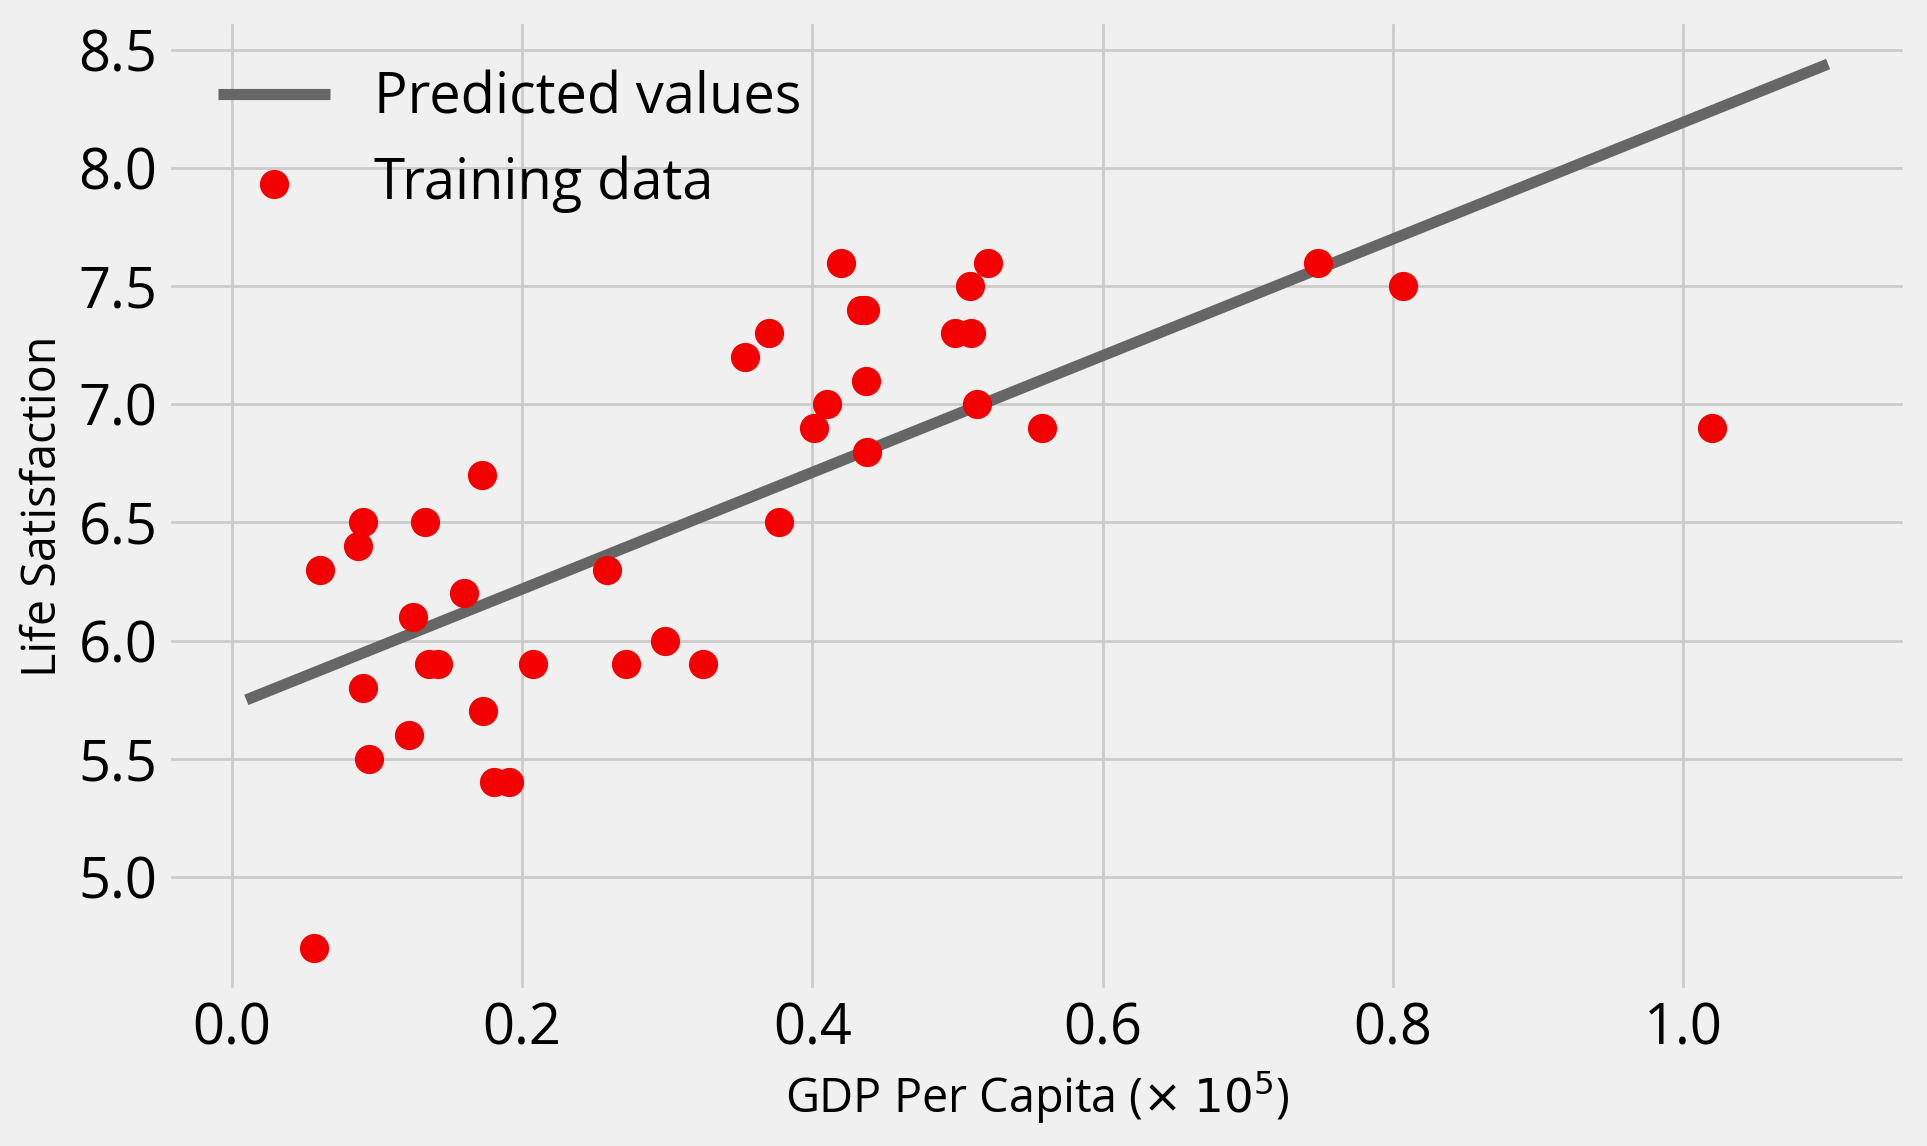

In [16]:
with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the predicted values
    ax.plot(X_pred / 1e5, y_pred, label="Predicted values", color="#666666")

    # Training data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Training data",
        s=100,
        zorder=10,
        color="#f40000",
    )

    ax.legend()
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")

### Not bad....but what did we do wrong?

<img src=https://media.giphy.com/media/1Bh2zyW2yuBEalV0rO/giphy.gif width=500></img>

### Two Problems!

#### 1. We also fit and evaluated our model on the same training set!

#### 2. We didn't scale our input data features!

Scikit learn provides a utility function to split our input data:

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# I'll use a 70/30% split
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

These are new DataFrame objects, with lengths determined by the split percentage:

In [19]:
print("size of full dataset = ", len(data))
print("size of training dataset = ", len(train_set))
print("size of test dataset = ", len(test_set))

size of full dataset =  40
size of training dataset =  28
size of test dataset =  12


Now, make our feature and label arrays:

In [20]:
# Features
X_train = train_set['gdp_per_capita'].values
X_train = X_train[:, np.newaxis]

X_test = test_set['gdp_per_capita'].values
X_test = X_test[:, np.newaxis]

# Labels
y_train = train_set['life_satisfaction'].values
y_test = test_set['life_satisfaction'].values

Use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the GDP per capita:

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()

In [23]:
# Scale the training features
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test features
X_test_scaled = scaler.fit_transform(X_test)

Now, let's fit on the *training set* and evaluate on the *test set*

In [24]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [25]:
model.score(X_test_scaled, y_test)

0.35959585147159556

**Unsurprisingly, our fit gets worst when we test on unseen data**

Our accuracy was artifically inflated the first time, since we trained and tested on the same data.

### Can we do better? Let's do some feature engineering...

We'll use scikit learn's [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to add new polynomial features from the GDP per capita.

In [26]:
from sklearn.preprocessing import PolynomialFeatures

#### Let's try up to degree 3 polynomials 

In [27]:
poly = PolynomialFeatures(degree=3)

### Now we have two transformations to make:

1. Scale our features
1. Create the polynomial features

In [28]:
# Training
X_train_scaled_poly = poly.fit_transform(scaler.fit_transform(X_train))

# Test
X_test_scaled_poly = poly.fit_transform(scaler.fit_transform(X_test))

In [29]:
X_train_scaled_poly.shape

(28, 4)

In [30]:
model.fit(X_train_scaled_poly, y_train)

LinearRegression()

In [31]:
model.score(X_test_scaled_poly, y_test)

0.5597457659851052

**The accuracy improved!**

### Pipelines: making multiple transformations *much* easier

We can turn our preprocessing steps into a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) object using the [`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) function.

In [32]:
from sklearn.pipeline import make_pipeline

In [33]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3))

pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3))])

Individual steps can be accessed via their names in a dict-like fashion:

In [34]:
# Step 1
pipe['standardscaler']

StandardScaler()

In [35]:
# Step 2
pipe['polynomialfeatures']

PolynomialFeatures(degree=3)

Let's apply this pipeline to our predicted GDP values for our plot:

In [36]:
y_pred = model.predict(pipe.fit_transform(X_pred))

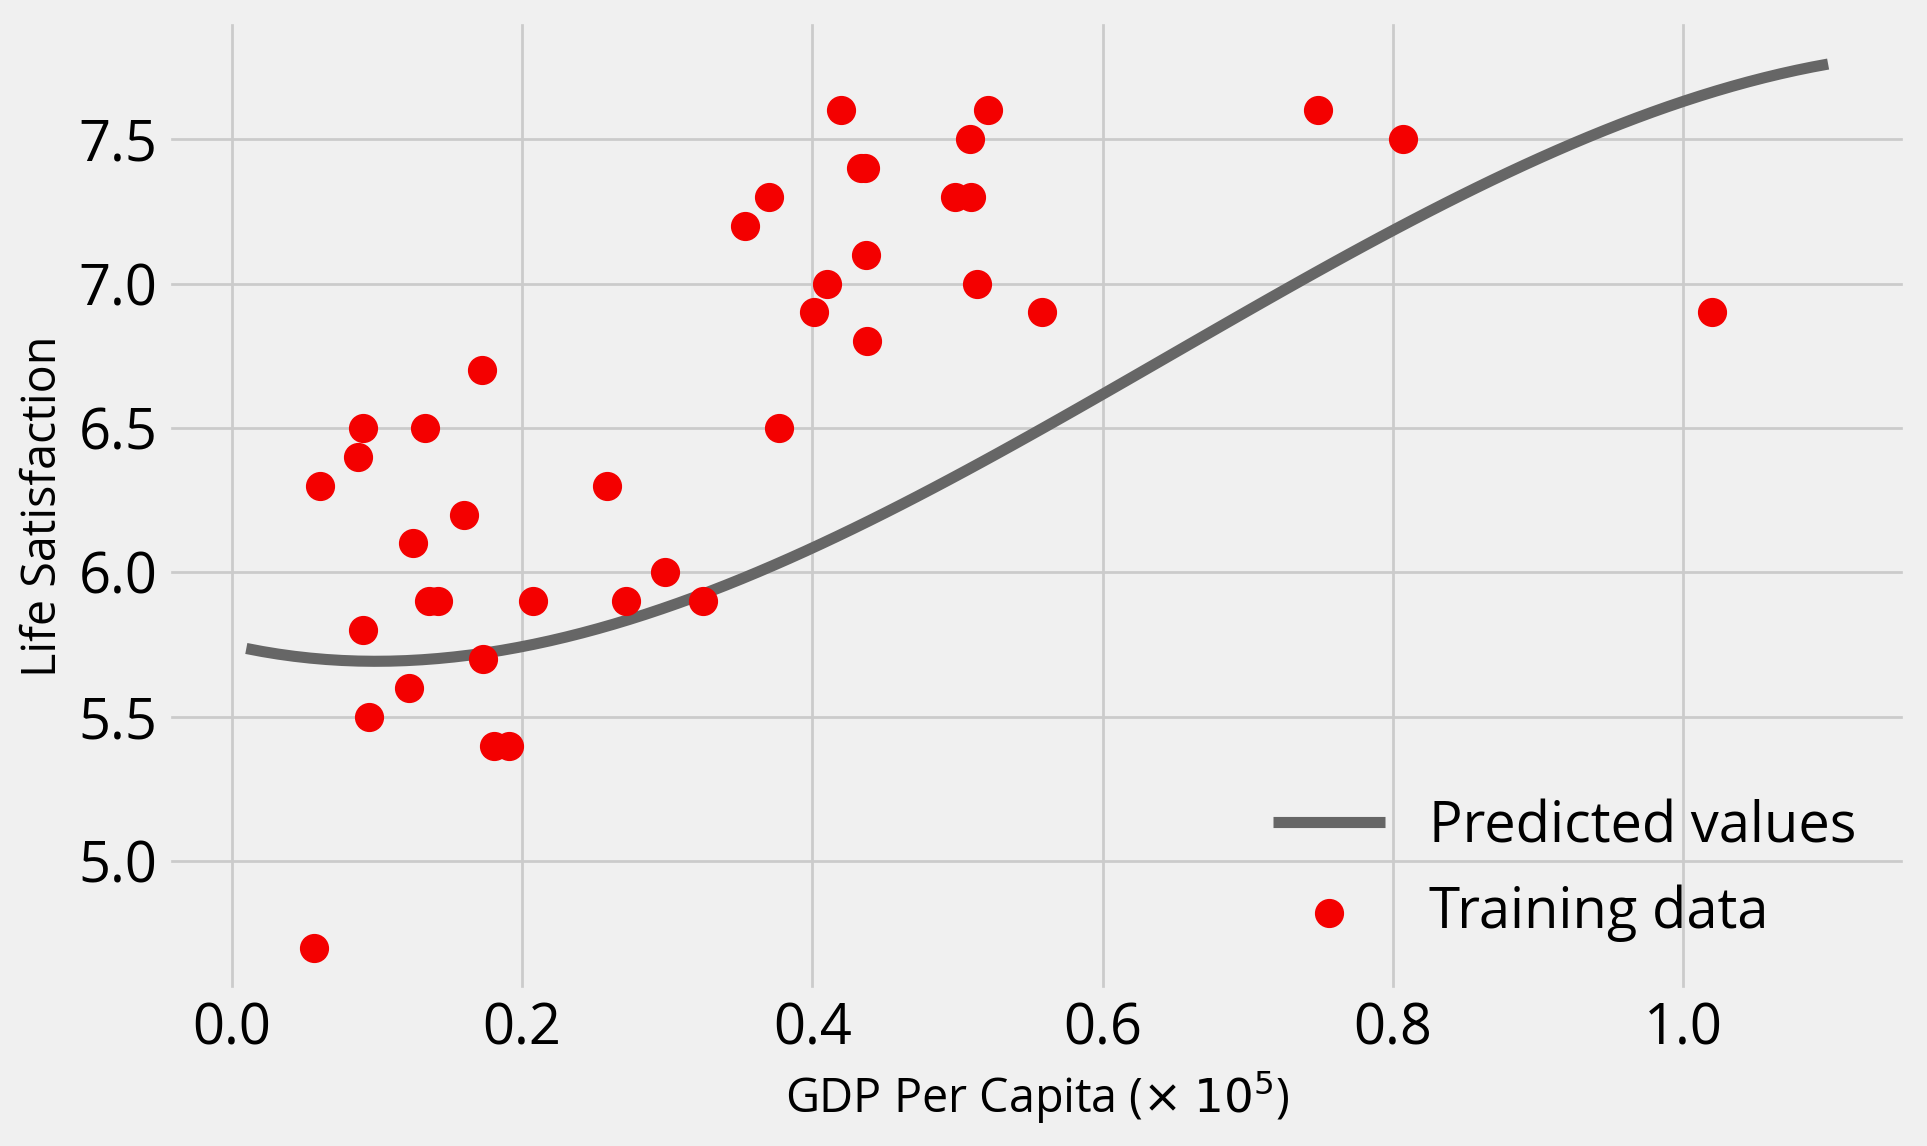

In [37]:
with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the predicted values
    y_pred = model.predict(pipe.fit_transform(X_pred))
    ax.plot(X_pred / 1e5 , y_pred, label="Predicted values", color="#666666")

    # Training data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Training data",
        s=100,
        zorder=10,
        color="#f40000",
    )

    ax.legend()
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction");
    plt.show()

**The additional polynomial features introduced some curvature and improved the fit!**

### How about large polynomial degrees?

degree = 3
Training Score = 0.6458898101593082
Test Score = 0.5597457659851052

degree = 5
Training Score = 0.684620618656437
Test Score = -3.9465752545551194

degree = 10
Training Score = 0.8020213670053926
Test Score = -26330.208554357756



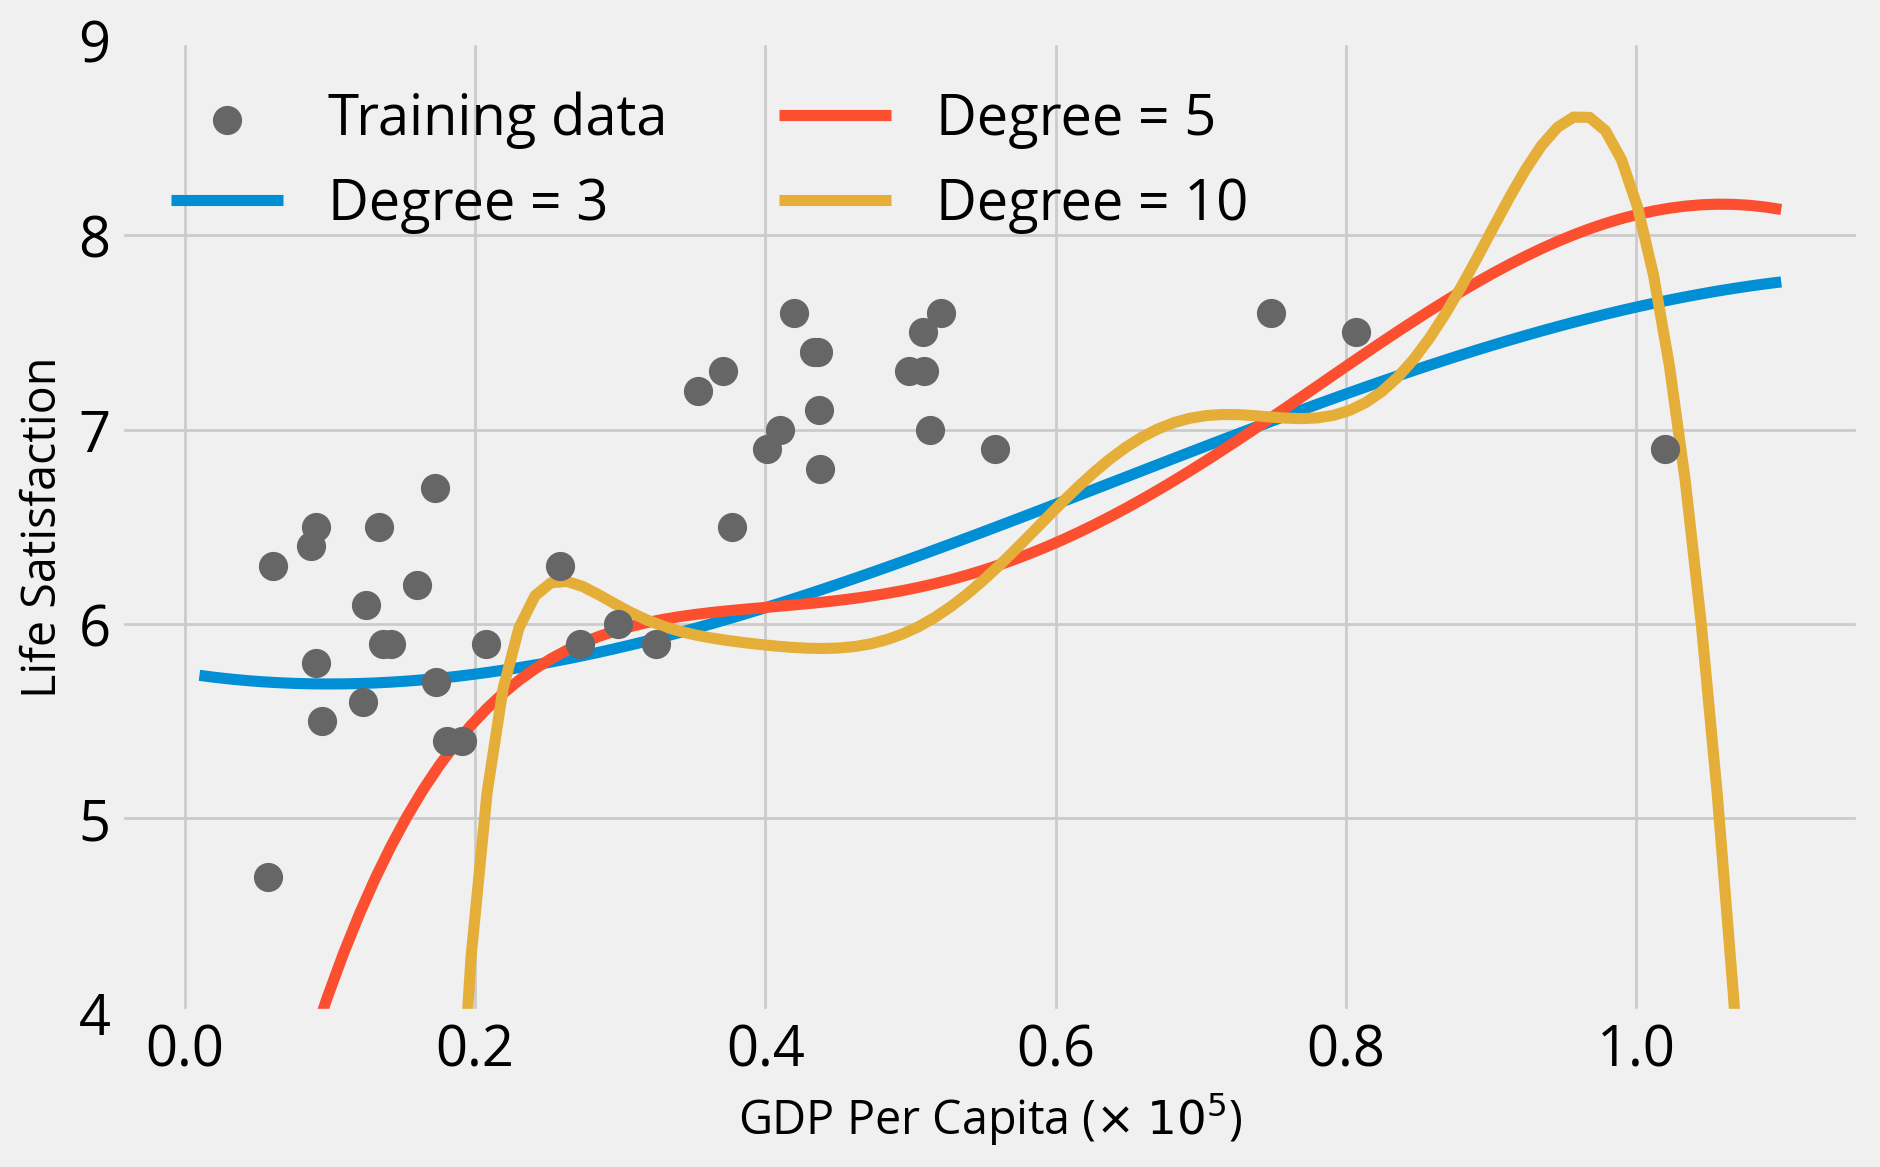

In [38]:
with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Original data set
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Training data",
        s=100,
        zorder=10,
        color="#666666",
    )
    
    # Plot the predicted values
    for degree in [3, 5, 10]:
        print(f"degree = {degree}")
        
        # Create out pipeline
        p = make_pipeline(StandardScaler(), PolynomialFeatures(degree=degree))
        
        # Fit the model on the training set
        model.fit(p.fit_transform(X_train), y_train)
        
        # Evaluate on the training set
        training_score = model.score(p.fit_transform(X_train), y_train)
        print(f"Training Score = {training_score}")
        
        # Evaluate on the test set
        test_score = model.score(p.fit_transform(X_test), y_test)
        print(f"Test Score = {test_score}")
        
        # Plot
        y_pred = model.predict(p.fit_transform(X_pred))
        ax.plot(X_pred / 1e5, y_pred, label=f"Degree = {degree}")
        
        print()

    ax.legend(ncol=2, loc=0)
    ax.set_ylim(4, 9)
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")
    plt.show();

### Overfitting alert!

As we increase the polynomial degree, two things happen:

1. Training accuracy goes way up 
1. Test accuracy goes way down
    
This is the classic case of overfitting — our model does not generalize well at all.

### Regularization to the rescue?

- The [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) adds regularization to the linear regression least squares model
- Parameter *alpha* determines the level of regularization
- Larger values of *alpha* mean stronger regularization — results in a "simpler" bestfit

**Remember, regularization penalizes large parameter values and complex fits**

Let's gain some intuition:

- Fix the polynomial degree to 3
- Try out alpha values of 0, 10, 100, and 1e5
- Compare to linear fit (no polynomial features)


**Important**
- Baseline: linear model
    - This uses `LinearModel` and scales input features with `StandardScaler`
- Ridge regression: try multiple regularization strength values
    - Use a pipeline object to apply both a `StandardScaler` and `PolynomialFeatures(degree=3)` pre-processing to features

In [39]:
from sklearn.linear_model import Ridge

Set up a grid of GDP per capita points to make predictions for:

In [40]:
# The values we want to predict (ranging from our min to max GDP per capita)
gdp_pred = np.linspace(1e3, 1.1e5, 100)

# Sklearn needs the second axis!
X_pred = gdp_pred[:, np.newaxis]

Linear fit
Training Score = 0.4638100579740343
Test Score = 0.35959585147159556

alpha = 0
Training Score = 0.6458898101593082
Test Score = 0.5597457659851048

alpha = 10
Training Score = 0.5120282691427858
Test Score = 0.38335642103788325

alpha = 100
Training Score = 0.1815398751108913
Test Score = -0.05242399995626967

alpha = 100000.0
Training Score = 0.0020235571180508005
Test Score = -0.26129559971586125



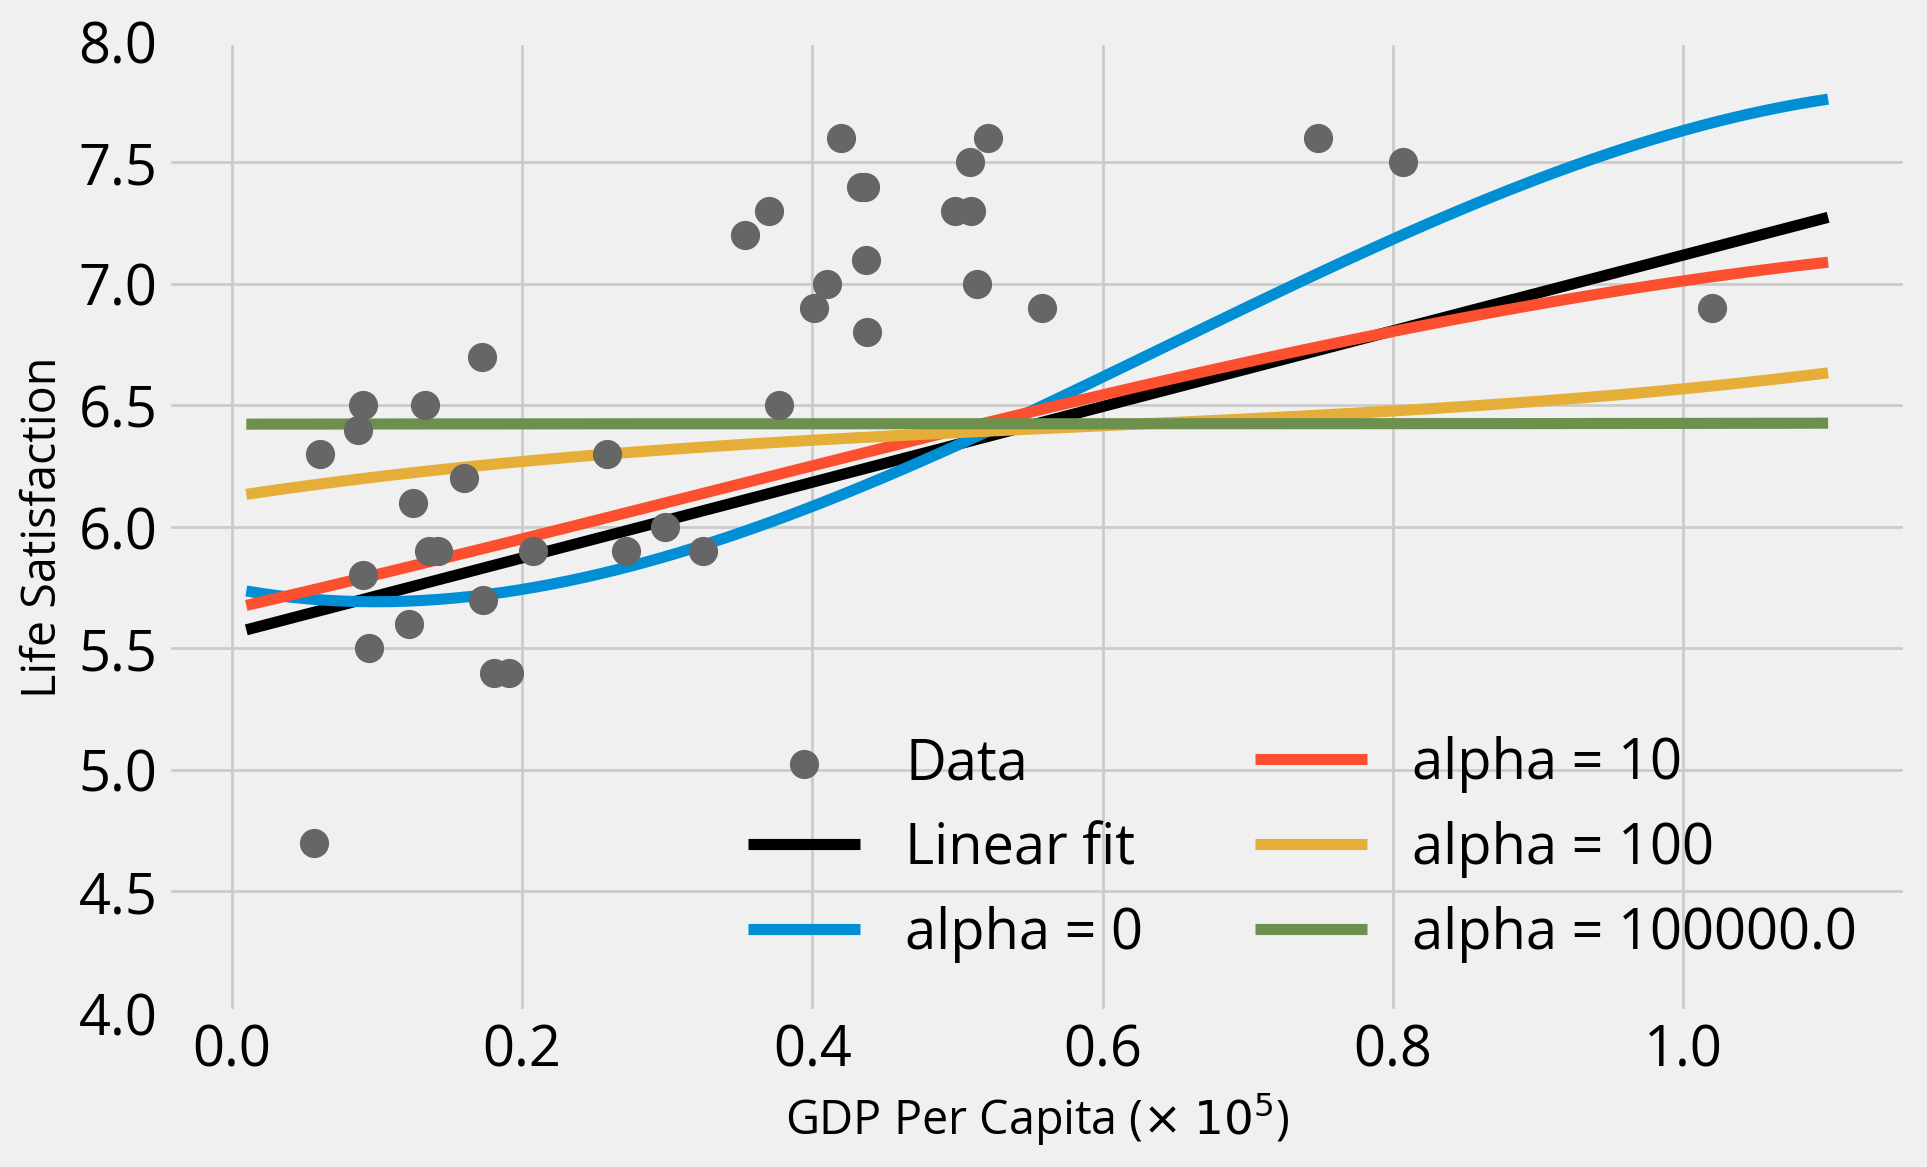

In [43]:
# Create a pre-processing pipeline
# This scales and adds polynomial features up to degree = 3
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3))

# BASELINE: Setup and fit a linear model (with scaled features)
linear = LinearRegression()
scaler = StandardScaler()
linear.fit(scaler.fit_transform(X_train), y_train)


with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    ## Plot the data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Data",
        s=100,
        zorder=10,
        color="#666666",
    )

    ## Evaluate the linear fit
    print("Linear fit")
    training_score = linear.score(scaler.fit_transform(X_train), y_train)
    print(f"Training Score = {training_score}")

    test_score = linear.score(scaler.fit_transform(X_test), y_test)
    print(f"Test Score = {test_score}")
    print()


    ## Plot the linear fit
    ax.plot(
        X_pred / 1e5,
        linear.predict(scaler.fit_transform(X_pred)),
        color="k",
        label="Linear fit",
    )

    ## Ridge regression: linear model with regularization 
    # Plot the predicted values for each alpha
    for alpha in [0, 10, 100, 1e5]:
        print(f"alpha = {alpha}")

        # Create out Ridge model with this alpha
        ridge = Ridge(alpha=alpha)

        # Fit the model on the training set
        # NOTE: Use the pipeline that includes polynomial features
        ridge.fit(pipe.fit_transform(X_train), y_train)

        # Evaluate on the training set
        training_score = ridge.score(pipe.fit_transform(X_train), y_train)
        print(f"Training Score = {training_score}")

        # Evaluate on the test set
        test_score = ridge.score(pipe.fit_transform(X_test), y_test)
        print(f"Test Score = {test_score}")

        # Plot the ridge results
        y_pred = ridge.predict(pipe.fit_transform(X_pred))
        ax.plot(X_pred / 1e5, y_pred, label=f"alpha = {alpha}")

        print()

    # Plot formatting
    ax.legend(ncol=2, loc=0)
    ax.set_ylim(4, 8)
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")
    plt.show()

### Takeaways

- As we increase alpha, the fits become "simpler" and coefficients get closer and closer to zero — a straight line!
- When alpha = 0 (no regularization), we get the same result as when we ran `LinearRegression()` with the polynomial features
- In this case, regularization doesn't improve the fit, and the base polynomial regression (degree=3) provides the best fit

## Recap: what we learned so far

- The LinearRegression model
- The test/train split and evaluation
- Feature engineering: scaling and creating polynomial features
- The Ridge model and regularization
- Creating Pipeline() objects


## That's it!

To be continued next time!